In [2]:
%matplotlib inline
import os

import jplus
#jplus_dir         =  '/home/CEFCA/aaorsi/work/j-plus/'
redmapper_dir     = '/home/CEFCA/aaorsi/work/redmapper/'
redmapperdata     = redmapper_dir + 'redmapper_dr8_public_v6.3_catalog.fits'
#tilesdata         = '%s/tiles/tiles_data_new.tsv' % elg_analysis_dir

import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits

#import elg_analysis as elg
import elgtools as tools_elg
import learn_elgs as learn_elg
import pickle

from astropy import units as u
from astropy.coordinates import SkyCoord

tile_scale = 1.40

rmin = -2
rmax =np.log10(tile_scale)
nbins = 20

rarr = np.linspace(rmin, rmax, nbins)
dr = rarr[1] - rarr[0]

#t_info = np.loadtxt(tilesdata) ## Old tile list info, don't use
#print 'tiles info read'
tiles = jplus.datasets.fetch_jplus_tile_list(db='dr1',overwrite=False)


j-plus [INFO]:    Downloading eBOSS ELG composite spectrum from https://data.sdss.org/sas/dr13/eboss/elg/composite/v1_0/eBOSS_ELG_composite.fits


[========================================]  92.8kb / 92.8kb   


j-plus [INFO]: Fetching J-PLUS Tile list
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/objects_tile_list_dr1_dual.h5


In [3]:
from functools import reduce

def get_distance(ra1, dec1, ra2, dec2):
  ra1 *= np.pi/180.
  ra2 *= np.pi/180.
  dec1 *= np.pi/180.
  dec2 *= np.pi/180.
  
# Angular distance for two sets of coordinates
  cosg = (np.cos(np.pi/2. - dec1)*np.cos(np.pi/2. - dec2) +
          np.sin(np.pi/2. - dec1)*np.sin(np.pi/2.-dec2)*np.cos(ra1 - ra2))
  
  return np.arccos(cosg)


def quick_dist(ra1, dec1, ra2, dec2, units='deg'):
  return np.sqrt( ((ra1 - ra2)*np.cos(dec1*np.pi/180))**2 + (dec1 - dec2)**2)

def haversine_dist(ra1, dec1, ra2, dec2):
  th1 = np.pi/2. - dec1 * np.pi/180.0
  th2 = np.pi/2. - dec2 * np.pi/180.0

  ph1 = ra1 * np.pi/180.0
  ph2 = ra2 * np.pi/180.0

  dph = np.abs(ph1 - ph2)
  dth = np.abs(th1 - th2)

  harg = np.sin(dph/2)**2 + np.cos(ph1)*np.cos(ph2) * np.sin(dth/2.)**2

  return 2 *np.arcsin(np.sqrt(harg)) * 180./np.pi  # Return distance in degrees


def skydist(ra1,dec1,ra2,dec2, units='deg'):
  
  n2 = len(ra2)

  if n2 != len(dec2):
    raise ValueError('ra, dec arrays have different number of elements')
  
  dist = np.zeros(n2)

  c1 = SkyCoord(ra1,dec1,unit=units)
  for i in range(n2):
    c2 = SkyCoord(ra2[i], dec2[i], unit=units)
    dist[i] = c1.separation(c2).radian

  return dist


  
def get_density(datadic,  weights, dfunc = haversine_dist,
               central_name='clusters', field_name='elgs'):  
  
  gal_arr = np.zeros(nbins)
  central = datadic[central_name]
  elgs    = datadic[field_name]
  tiles   = datadic['tiles']
  ncentral  = len(central['ra'])
    
  # dfunc = quick_dist  # Define which distance calculator to use
  # dfunc = haversine_dist # get_distance  # Define which distance calculator to use
  
  print 'central objects loaded, %d clusters' % ncentral

  # Select only those central objects 
  # near a J-PLUS tile
  
  elgtiles = np.unique(elgs['tile_id'])
        
  ntiles = len(elgtiles)
  print 'ELG sample is contained in %d tiles' % ntiles
  print 'scanning tiles..'
 
  ktot = 0
  wtot = 0.0
  for i in range(ncentral):
    idc = i
    dist = dfunc(central['ra'][idc], central['dec'][idc], tiles['ra'], 
                tiles['dec'])
    idist = np.argmin(dist)
    mindist = dist[idist]

    if mindist < tile_scale:
      idtt = np.where(elgtiles == tiles['tile_id'][idist])[0] # Tile with central obj contains ELGs
      
      if len(idtt) != 1:
        continue # len(idtt) = 0 would mean that this tile is empty -- not observed or bad photometry

      iw = weights[idist]  
      sel_tile = np.where(elgs['tile_id'] == tiles['tile_id'][idist])[0]
      ngals = len(sel_tile)
  
      ktot += 1.0 # Tile contains central galaxy + ELGs around it.
      wtot += iw
      for k in range(ngals):
        idg = sel_tile[k]
        dist = np.log10(dfunc(central['ra'][idc], central['dec'][idc], 
        elgs['coords'][idg,0], elgs['coords'][idg,1]))

        if dist < rmax:
          dbin = int((dist  - rmin)/dr)
          gal_arr[dbin:] += iw

#    if ktot == 79:
#      break

  print gal_arr/ktot/wtot

  print 'N centers: ',ktot
  return gal_arr/ktot


def plot_densities(d1,label):
  import matplotlib.pyplot as plt
  vol_r = np.pi*(10**rarr)**2

  for d, l in zip(d1, label):
      plt.semilogy(rarr, d/vol_r,label=l,linewidth=3)

  plt.legend(fontsize=20, loc='upper left')

  plt.xlabel(r'$\log(\theta [{\rm deg}])$',fontsize=20)
  plt.ylabel(r'$\langle n \rangle (\leq r) [{\rm deg}^{-2}]$',fontsize=20)

  plt.xlim([rarr.min(),rarr.max()])
  #plt.ylim([np.min([d1v,d2v]), d2v.max()])

  plt.show()

  return 1


In [4]:
# A key function here:

def load_catalogues(elgs = None, clusters = redmapperdata, random_mask='' , 
                    zrange=[.3,.35], find_tiles = False, tile_list = -1, 
                    tile_scale=1.40, crossmatch_all = True):

# if find_tiles, then central objects will be restricted to those within a tile. Thus, tile_list must contain a dictionary of tiles.

    if find_tiles and tile_list == -1:
        print 'load_catalogues() ERROR: Tiles needed in tile_list keyword'
        return {}
    
# Function to load elgs and redmapper catalogues

    
    print 'ELG catalogue loaded'
    nelgs = len(elgs['tile_id'])
    raw_central = fits.open(clusters)
    central0     = raw_central[1].data
    zsel = np.where((central0['z_lambda'] > zrange[0]) & (central0['z_lambda'] < zrange[1]))[0]
    ncentral = len(zsel)
    central_ = central0[zsel]

    if find_tiles:
        cent = {'coords': np.asarray([ [central_['ra'][i], central_['dec'][i]] 
                                  for i in range(ncentral)])}
    
        d, ind = jplus.tools.crossmatch_angular(cent['coords'], tile_list['coords'], 
                                            max_distance=tile_scale*np.sqrt(2))
        
        tiles_central = np.zeros(ncentral)
        m = []
        for i in range(ncentral):
            darr = haversine_dist(cent['coords'][i,0], cent['coords'][i,1], tile_list['ra'], tile_list['dec'])
            idt2 = np.argsort(darr)[0]  
            tiles_central[i] = tile_list['tile_id'][idt2] 
            m.append(True if darr[idt2] < tile_scale*np.sqrt(2)/2. else False)
        
       
        central = jplus.tools.select_object(cent, m)
        central['tile_id'] = tiles_central[m]
        
        Test_Tiles_XMatch = True
        if Test_Tiles_XMatch:
            # This will reproduce the above procedure on the ELGs to compare against their actual tile_id from the catalogue
            
            #print tile_list['ra'][0:100]
            
            tile2 = np.zeros(nelgs)
            for i in range(nelgs):
                idt2 = np.argsort(haversine_dist(elgs['coords'][i,0], elgs['coords'][i,1], tile_list['ra'], tile_list['dec']))[0]  
                tile2[i] = tile_list['tile_id'][idt2]
          
        
    if 'ra' not in central:
        central['ra'] = central['coords'][:,0]
        central['dec'] = central['coords'][:,1]
    
    
    print 'finding tile_id of random points...'
    nran = len(random_mask['coords'])
    print 'initial number of randoms %ld' % nran
    ran_tile_id = np.zeros(nran)
     
    m = []
    for i in range(nran):
            darr = haversine_dist(random_mask['coords'][i,0], random_mask['coords'][i,1], tile_list['ra'], tile_list['dec'])
            idt2 = np.argsort(darr)[0]  
            ran_tile_id[i] = tile_list['tile_id'][idt2] 
            m.append(True if darr[idt2] < 2*tile_scale else False)
            if i%10000 == 0:
                print float(i)/float(nran)
    
    randict = jplus.tools.select_object(random_mask, m)
    randict['tile_id'] = ran_tile_id[m]
    
    print 'final number of rans: %ld' % len(randict['tile_id'])
    
    if crossmatch_all:
        print 'Returning only ELGs, Redmapper clusters and random mask tiles with overlapping tiles'
        
        unique_tiles = reduce(np.intersect1d, (np.unique(elgs['tile_id']), 
                                               np.unique(central['tile_id']),
                                               np.unique(randict['tile_id'])))
        print 'number of intersecting tiles', len(unique_tiles)
        
        
        reduced_elgs     = jplus.tools.select_object(elgs, np.array([item in unique_tiles for item in elgs['tile_id'] ]))
        reduced_random   = jplus.tools.select_object(randict, np.array([item in unique_tiles for item in randict['tile_id'] ]))
        reduced_clusters = jplus.tools.select_object(central, np.array([item in unique_tiles for item in central['tile_id'] ]))
        reduced_tiles    = jplus.tools.select_object(tile_list, np.array([item in unique_tiles for item in tile_list['tile_id'] ]))
    
        out = {'elgs': reduced_elgs, 
              'clusters': reduced_clusters,
              'randoms': reduced_random,
              'tiles': reduced_tiles}
    else:
        out = {'elgs': elgs, 
              'clusters': central,
              'randoms': randict,
              'tiles': tile_list}
    
    return out


In [5]:
# Load catalogues
import pickle

elgfile = 'ELG_cand.data'
ranfile = 'random_mask.data'

#elgs = pickle.load(open(elgfile))
#ran = pickle.load(open(ranfile))

#print elgs.keys()
#print ran.keys()
#print 'Catalogues loaded OK'


# Get all galaxies from J-PLUS
mag_type = 'gpsfMags'
gal_jplus0 = jplus.datasets.fetch_jplus_objects(mag_type=mag_type, overwrite=False, 
                                                 object_name="jplus_pz", nchunks=20, mag_limit=[16,24.],
                                                extra_where_conds='',db='dr1', allphotoz=True, upperlimparams=True)
    
   


j-plus [INFO]: Fetching J-PLUS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/jplus_jplus_pz_gpsfMags_dr1_dual_magmax24.0.h5


In [6]:
# define red galaxies within the correct photo-z range
import elgtools as elg
f_j0660 = jplus.datasets.fetch_jplus_filter('J0660') # Filter transmission curve

w_hb = 4861.0
z_hb = elg.zline(w_hb, f_j0660.wave, f_j0660.throughput)

w_oiii = 5007.0
z_oiii = elg.zline(w_oiii, f_j0660.wave, f_j0660.throughput)

pz_range = [np.min([z_hb, z_oiii]), np.max([z_hb, z_oiii])]
print pz_range

mg = gal_jplus0['gJAVA'][:,0]
mr = gal_jplus0['rJAVA'][:,0]
mi = gal_jplus0['iJAVA'][:,0]
Cf = 0.7

cperp = np.abs((mr - mi) - (mg - mr)/4.0 -0.18)
cpar  = Cf*(mg - mr) + (1-Cf)*4.0*((mr - mi) - 0.18)


snr_limit = 5 # Minimum SNR for r, i and J0660

mc = ((gal_jplus0['mask_flags_rJAVA'] == 0) &
     (1./gal_jplus0['rJAVA'][:,1] > snr_limit)) 

lrg_mask = (mr < 13.1 + cpar/0.3) & (gal_jplus0['photoz_tpz'] > pz_range[0]) & (gal_jplus0['photoz_tpz'] < pz_range[1]) & mc

lrg_jplus = jplus.tools.select_object(gal_jplus0, lrg_mask)

print 'Number of LRGs: %ld' % len(lrg_jplus['tile_id'])






j-plus [INFO]: Fetching  J-PLUS filters


[0.30129710948226485, 0.37735007668633419]
Number of LRGs: 15152


In [7]:
#def elg_clusters():
import pymangle
CreateRandoms = False # False implies reading them from a file
RanFile = 'random_mask.data'

elgs = pickle.load(open(elgfile))

if CreateRandoms:
    print 'Creating random mask file...'
    ran = mask.create_random(3e5)
    print 'Nrandom: %ld' % nran
    with open(RanFile,'wb') as outfile:
        pickle.dump(randict,outfile,protocol=pickle.HIGHEST_PROTOCOL)
else:
    print 'Reading random mask file ...'
    ran = pickle.load(open(RanFile))


tcoords = {'coords': np.asarray([ [tiles['ra'][i], tiles['dec'][i]] for i in range(len(tiles['ra'])) ]),
          'tile_id': tiles['ref_tileID'],
          'ra': tiles['ra'],
          'dec':tiles['dec']}

mastercat = load_catalogues(elgs=elgs, clusters= redmapperdata, 
                            find_tiles=True, tile_list=tcoords,random_mask=ran)

lrgcat = load_catalogues(elgs=lrg_jplus, clusters= redmapperdata, 
                            find_tiles=True, tile_list=tcoords,random_mask=ran)

tcenter = {'ra':tiles['ra'], 'dec':tiles['dec']}

mask_clusters = {}  # Randoms around clusters
mask_clusters['elgs'] = mastercat['randoms']
mask_clusters['central'] = mastercat['clusters']


mask_tile = {}     # Randoms around tile centres
mask_tile['elgs'] = mastercat['randoms']
mask_tile['central'] = mastercat['tiles']


elgs_tile = {}     # ELGs around tiles
elgs_tile['elgs'] = mastercat['elgs']
elgs_tile['central'] = mastercat['tiles']

lrgs_tile = {}     # LRGs around tiles
lrgs_tile['elgs'] = lrgcat['elgs']
lrgs_tile['central'] = lrgcat['tiles']

  

Reading random mask file ...
ELG catalogue loaded
finding tile_id of random points...
initial number of randoms 100000
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
final number of rans: 99904
Returning only ELGs, Redmapper clusters and random mask tiles with overlapping tiles
number of intersecting tiles 203
ELG catalogue loaded
finding tile_id of random points...
initial number of randoms 100000
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
final number of rans: 99904
Returning only ELGs, Redmapper clusters and random mask tiles with overlapping tiles
number of intersecting tiles 214


In [8]:
print tiles.keys()

['ncombined', 'noise', 'min_ra', 'ADUlevel', 'tileIDs', 'texposed', 'min_dec', 'ref_tileID', 'filter', 'depth', 'effectime', 'max_dec', 'ra', 'SQL', 'date', 'max_ra', 'dec', 'fwhmg']


In [9]:
print tiles['ref_tileID'], tiles['tileIDs']

print elgs['SQL_query']


[25998 25998 25998 ..., 34197 34197 34197] [26006 26002 26003 ..., 34228 34229 34084]
SELECT m.alpha_j2000 as ra, m.delta_j2000 as dec, t.DATASUM as datasum, 
   m.FWHM_WORLD*3600 as fwhm, m.CLASS_STAR as cstar, m.tile_id as tile_id, m.number as object_id, 
   m.KRON_RADIUS as kron_rad, m.PETRO_RADIUS as petro_rad, m.MU_MAX[jplus::rSDSS] as mu_max_r, 
   m.mag_aper3_gauss[jplus::uJAVA] as uJAVA, m.mag_err_aper3_gauss[jplus::uJAVA] as uJAVA_err, 
   m.mag_aper3_gauss[jplus::gSDSS] as gJAVA, m.mag_err_aper3_gauss[jplus::gSDSS] as gJAVA_err, 
   m.mag_aper3_gauss[jplus::rSDSS] as rJAVA, m.mag_err_aper3_gauss[jplus::rSDSS] as rJAVA_err, 
   m.mag_aper3_gauss[jplus::iSDSS] as iJAVA, m.mag_err_aper3_gauss[jplus::iSDSS] as iJAVA_err, 
   m.mag_aper3_gauss[jplus::zSDSS] as zJAVA, m.mag_err_aper3_gauss[jplus::zSDSS] as zJAVA_err, 
   m.mag_aper3_gauss[jplus::J0378] as J0378, m.mag_err_aper3_gauss[jplus::J0378] as J0378_err, 
   m.mag_aper3_gauss[jplus::J0395] as J0395, m.mag_err_aper3_gauss[jpl

In [ ]:
import pickle
elgs = pickle.load(open(elgfile))
ngal = len(elgs['tile_id'])
print ngal
#print len(tiles['tileIDs'])

#print tiles['tileIDs'][0:10]

for i in range(ngal):
    elgtile = elgs['tile_id'][i]
    elgc = elgs['coords'][i]
    idt = np.where(tiles['tileIDs'] == elgtile)
    
    within_tile = map(lambda min_ra, max_ra, min_dec, max_dec: (elgc[0]>min_ra) & (elgc[1]<max_ra) & (elgc[1]>min_dec) & (elgc[1]<max_dec),
                     tiles['min_ra'], tiles['max_ra'], tiles['min_dec'], tiles['max_dec'])   
    
    idt2 = np.where(within_tile)[0]
    #print i, tiles['ref_tileID'][idt2]
    
    #idt2 = np.argsort(quick_dist(elgs['coords'][i,0], elgs['coords'][i,1], tcoords['ra'], tcoords['dec']))[0]  
    tile2 = tcoords['tile_id'][idt2]
    print tile2 - elgtile

 
    
    

In [ ]:
hp = jplus.healpix.HealpixMap(elgs['coords'][:,:], average=False, nside=256)#, value=obj_jplus['rJAVA'][good,0])
hmap = hp.plot(interactive=False, title="Average J0660 magnitude")

In [ ]:
hp = jplus.healpix.HealpixMap(randict['coords'], average=False, nside=256)#, value=obj_jplus['rJAVA'][good,0])
hmap = hp.plot(interactive=False, title="Average J0660 magnitude")

In [ ]:
print g4

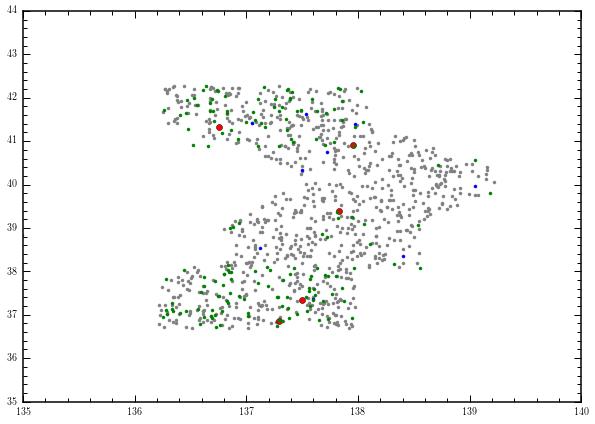

In [17]:
plt.figure(12)
ran      = mastercat['randoms']
elgs     = mastercat['elgs']
clusters = mastercat['clusters']
t2       = mastercat['tiles']
lrg      = lrgcat['elgs']
plt.rcParams['figure.figsize'] = 15,5

plt.plot(ran['coords'][:,0],ran['coords'][:,1], '.',color='gray')
plt.plot(elgs['coords'][:,0],elgs['coords'][:,1], '.',color='blue')
#rm = mastercat['central']
plt.plot(clusters['coords'][:,0],clusters['coords'][:,1], 'o',color='red')
plt.plot(lrg['coords'][:,0],lrg['coords'][:,1], '.',color='green')
#plt.plot(t2['ra'], t2['dec'], '.', color='magenta')
plt.xlim([135,140])
plt.ylim([35,44])

plt.show()



nrandoms:40662


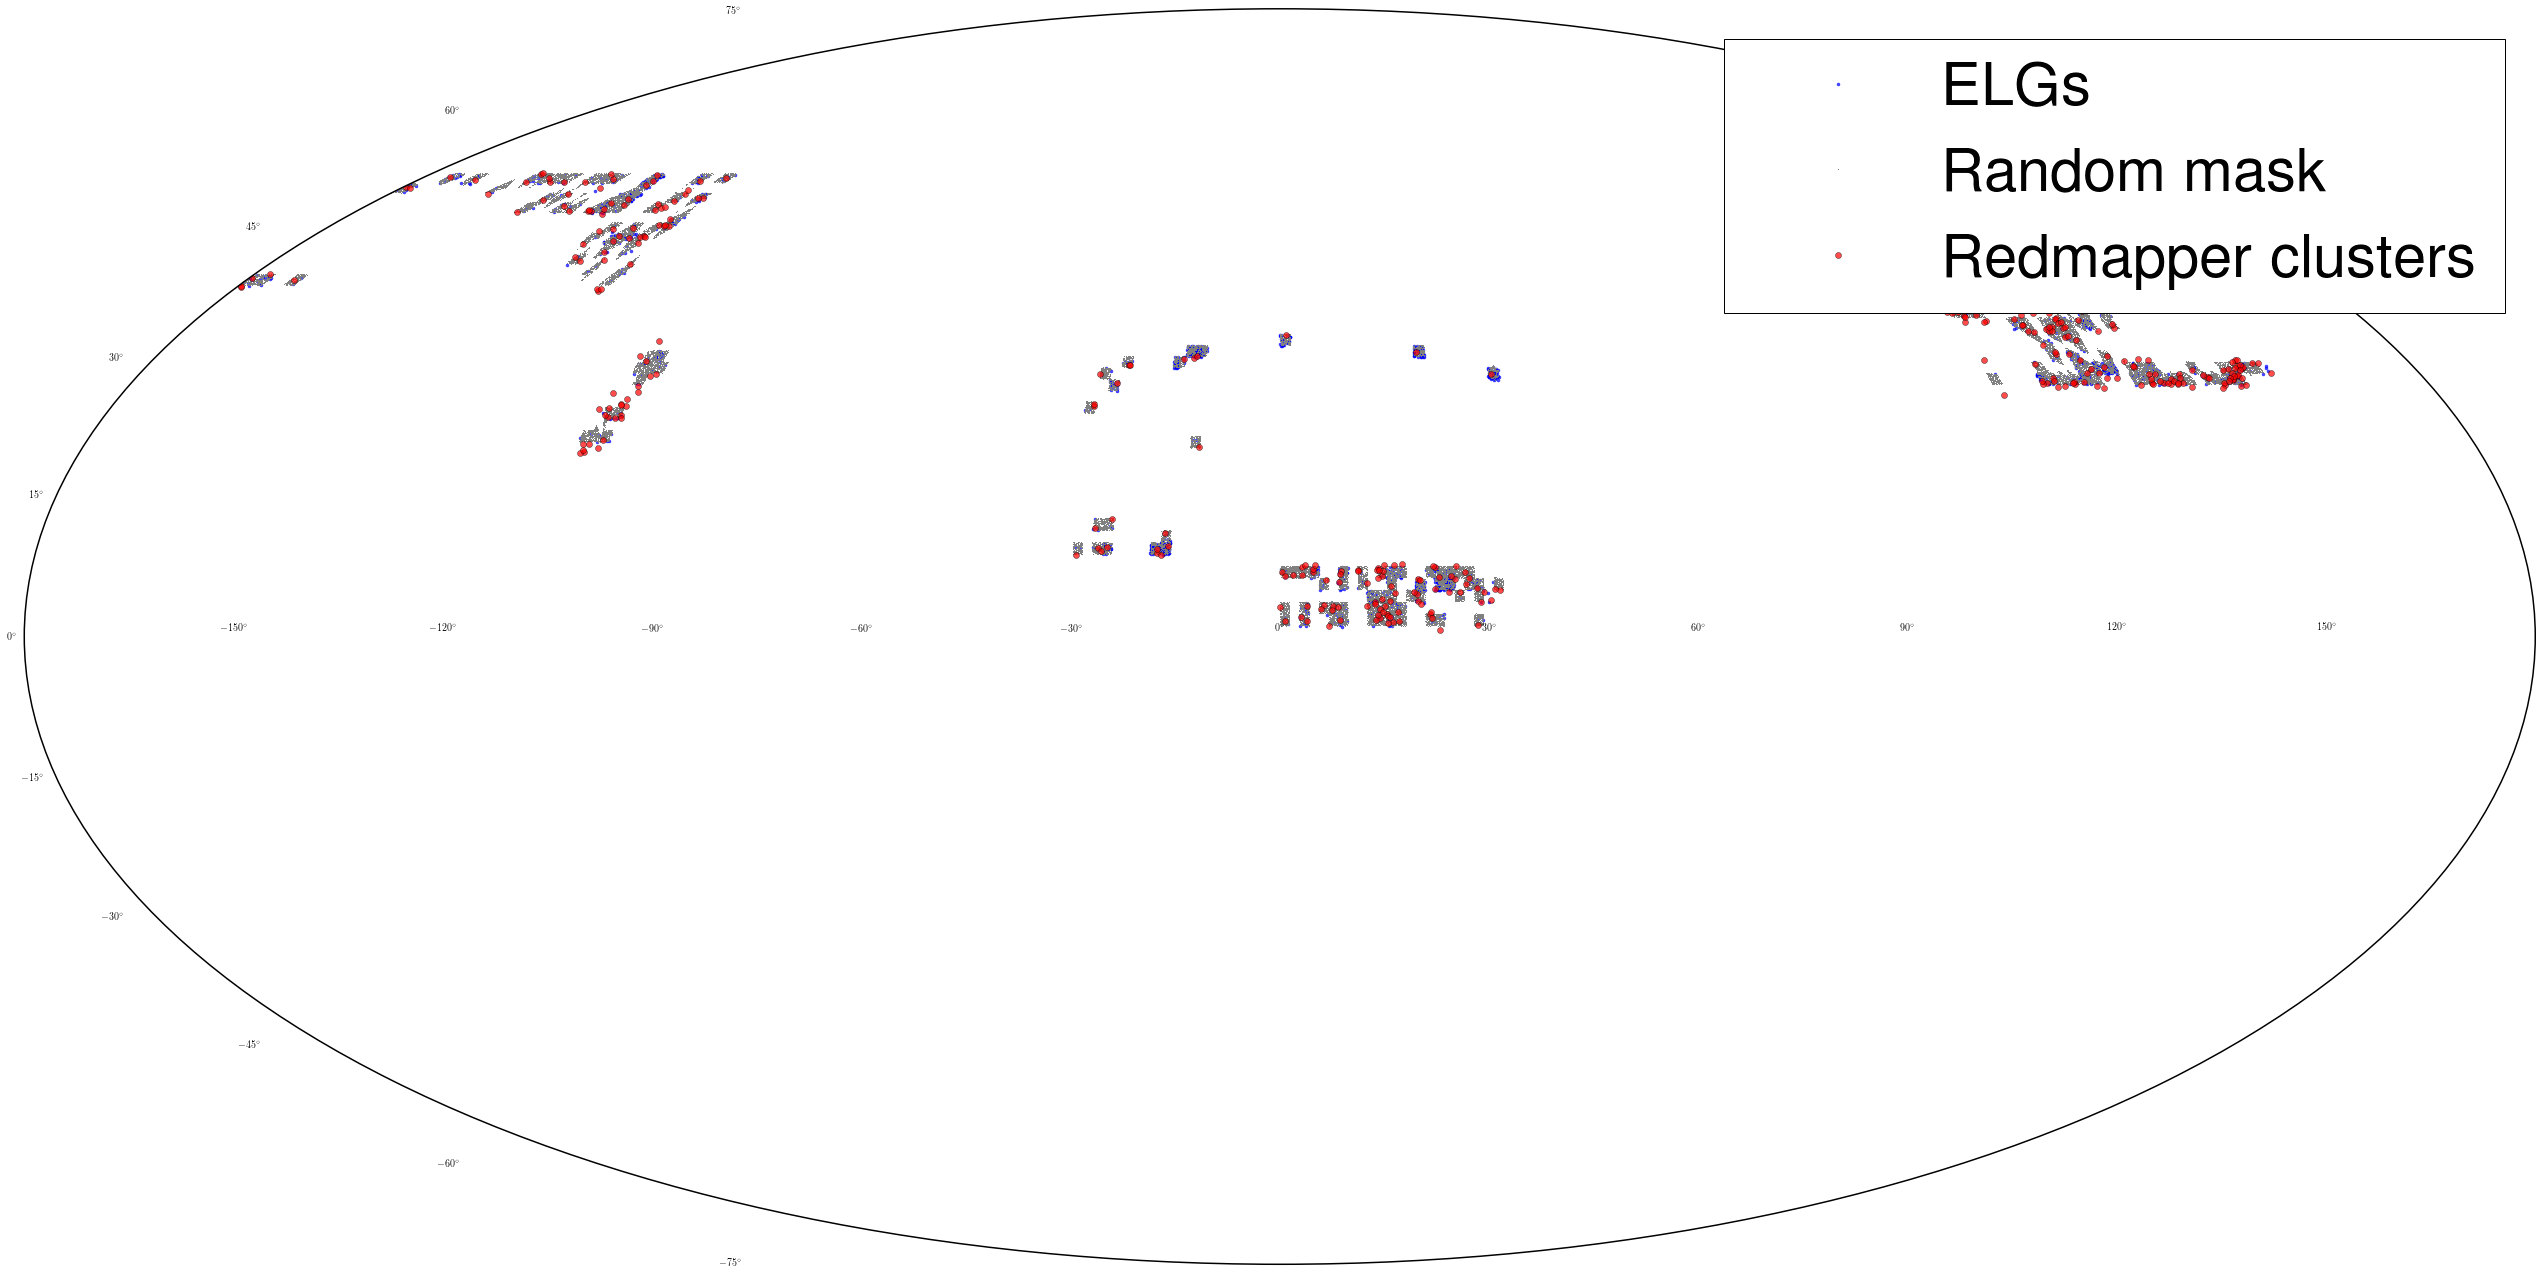

In [11]:
import astropy.coordinates as coord
import astropy.units as u
plt.rcParams['figure.figsize'] = 45, 45

elgs = mastercat['elgs']
ran  = mastercat['randoms']
clusters = mastercat['clusters']

ljp = len(elgs['coords'])
#jpid = np.random.random_integers(0,ljp,int(ljp/1000))
jpid = np.arange(0,ljp)

ra = coord.Angle(elgs['coords'][jpid,0]*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(elgs['coords'][jpid,1]*u.degree)

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
ax.plot(ra.radian, dec.radian,'.', label='ELGs', alpha=0.7, color='blue')

#counts, ybins, xbins, image = plt.hist2d(ra.radian, dec.radian, bins=250, 
#                                         cmap=plt.cm.Greys, normed=LogNorm(), 
#                                         cmin=0.01, label='J-PLUS', alpha=0.8)

lw = len(ran['coords'])
print 'nrandoms:%ld' % lw
#wid = np.random.random_integers(0,lw,int(lw/100))
wid = np.arange(0,lw)
ra_2 = coord.Angle(ran['coords'][wid,0]*u.degree)
ra_2 = ra_2.wrap_at(180*u.degree)
dec_2 = coord.Angle(ran['coords'][wid,1]*u.degree)

#counts, ybins, xbins, image = plt.hist2d(ra_2.radian, dec_2.radian, bins=250, 
#                                         cmap=plt.cm.Blues, normed=LogNorm(), 
#                                         cmin=0.01, label='WiggleZ', alpha=0.8)

ax.plot(ra_2.radian, dec_2.radian,',',alpha=1,color='gray', label='Random mask')

ljp = len(clusters['coords'])
#jpid = np.random.random_integers(0,ljp,int(ljp/1000))
jpid = np.arange(0,ljp)

ra = coord.Angle(clusters['coords'][jpid,0]*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(clusters['coords'][jpid,1]*u.degree)


ax.plot(ra.radian, dec.radian,'o', label='Redmapper clusters', alpha=0.7, color='red')


ax.legend(fontsize=60)

Number of tiles available: 6132
Number of tiles in groupby: 203


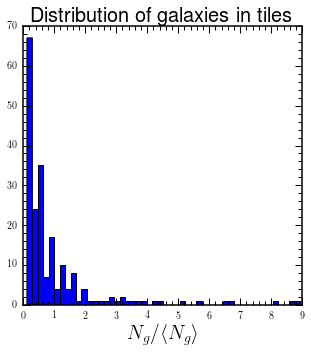

In [14]:
tile, mag, total = jplus.plotting.groupbytile(elgs['tile_id'], elgs['J0660'][:,0])
#print tile
#print mag
#print total

weights = np.asarray(total)/(np.mean(total)+0.0)
#print weights
ntile = len(tiles['tileIDs'])
#print tiles['tileIDs']

wtile = np.zeros(ntile)
k = 0
for itile in tiles['tileIDs']:
    idd = np.where(tile == itile)[0]
    if len(idd) == 1:
        wtile[k] = 1./weights[idd]
    else:
        wtile[k] = 0.0
    k +=1

#print wtile
#print len(np.where(wtile == 0)[0])/(ntile+0.0)

print 'Number of tiles available: %ld' % ntile
print 'Number of tiles in groupby: %ld' % len(tile)
plt.rcParams['figure.figsize'] = 5, 5

plt.figure(666)

plt.hist(weights,bins=50)
plt.xlabel(r'$N_g/\langle N_g \rangle',fontsize=20)
plt.title('Distribution of galaxies in tiles',fontsize=20)



In [15]:

ntiles = len(mastercat['tiles']['tile_id'])
g1 = get_density(mastercat, np.ones(ntiles))
g2 = get_density(mastercat, np.ones(ntiles), field_name='randoms' )

g3 = get_density(mastercat, np.ones(ntiles), central_name='tiles')
g4 = get_density(mastercat, np.ones(ntiles), central_name='tiles', field_name='randoms')

ntiles = len(lrgcat['tiles']['tile_id'])
lg1 = get_density(lrgcat, np.ones(ntiles))
lg2 = get_density(lrgcat, np.ones(ntiles), field_name='randoms' )

lg3 = get_density(lrgcat, np.ones(ntiles), central_name='tiles')
lg4 = get_density(lrgcat, np.ones(ntiles), central_name='tiles', field_name='randoms')




central objects loaded, 356 clusters
ELG sample is contained in 203 tiles
scanning tiles..
[  7.89041788e-06   7.89041788e-06   2.36712536e-05   3.94520894e-05
   6.31233430e-05   8.67945966e-05   1.42027522e-04   2.28822118e-04
   3.47178387e-04   6.23343012e-04   9.07398056e-04   1.38082313e-03
   2.23298826e-03   3.52701679e-03   5.52329251e-03   8.18236334e-03
   1.21433531e-02   1.64830829e-02   2.02704835e-02   2.02783739e-02]
N centers:  356.0
central objects loaded, 356 clusters
ELG sample is contained in 203 tiles
scanning tiles..
[  1.02575432e-04   2.05150865e-04   3.55068804e-04   6.15452594e-04
   1.08887767e-03   1.98838530e-03   3.36920843e-03   5.25501831e-03
   8.65578841e-03   1.42737659e-02   2.39395278e-02   3.90338972e-02
   6.23579725e-02   9.72336195e-02   1.52253503e-01   2.29224530e-01
   3.29582755e-01   4.39725098e-01   5.28776354e-01   5.28792135e-01]
N centers:  356.0
central objects loaded, 2436 clusters
ELG sample is contained in 203 tiles
scanning tiles.

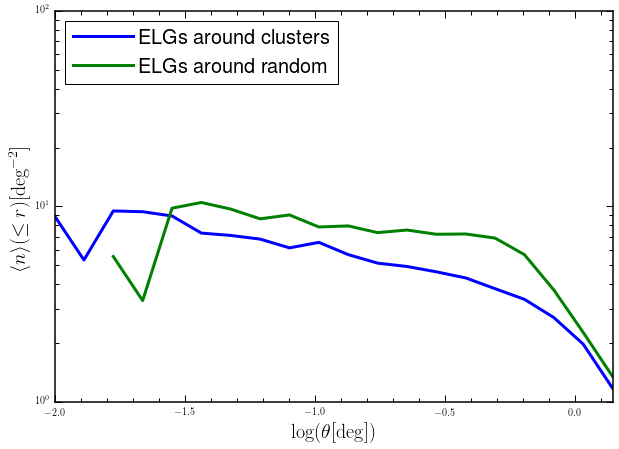

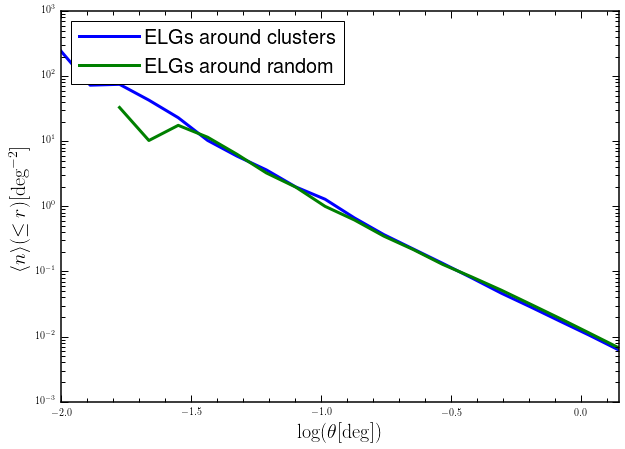

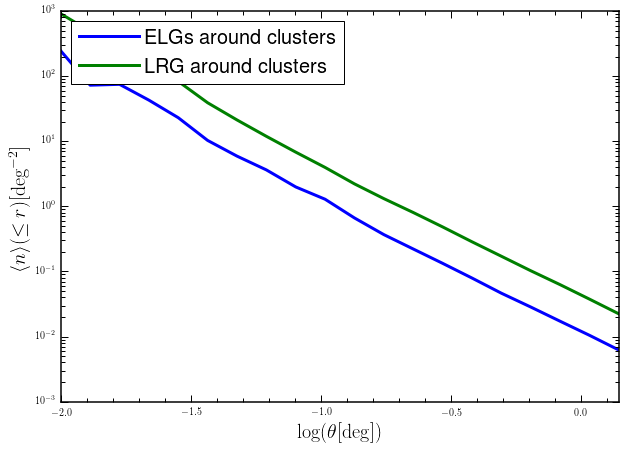

1

In [16]:
plt.rcParams['figure.figsize'] = 10, 7
plt.figure(11)
plot_densities([g1,g3],['ELGs around clusters', 
                              'ELGs around random'])
plt.figure(22)
plot_densities([g1/g2,g3/g4],['ELGs around clusters','ELGs around random'])

plt.figure(33)
plot_densities([g1/g2,lg1/lg2],['ELGs around clusters','LRG around clusters'])




In [ ]:
plt.figure()

tnumber = 0
tid = tiles['tileIDs'][tnumber]
print tid
mask = randict['tile_id'] == randict['tile_id'][0]
print mask[mask == True]
plt.plot(ran['coords'][mask,0]-tiles['ra'][tnumber],ran['coords'][mask,1]-tiles['dec'][tnumber],'o')

In [ ]:
tile, mag, total = jplus.plotting.groupbytile(elgs['tile_id'], elgs['J0660'][:,0])
plt.figure()
plt.plot(tile, mag,'o')
print tile, total

In [ ]:
len(elgs['tile_id'])
